# Import packages

In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [53]:
data_file_name = 'dataset.xlsx'
data_dir_path = '.'
data_file_path = os.path.join(data_dir_path, data_file_name)
print(data_file_path)
# Load 'data' spreadsheet
df = pd.read_excel(open(data_file_path, 'rb'), sheetname='data', header=1)

print(df.head())
print(df.columns)

./dataset.xlsx
        Date    KOSPI  KOSDAQ  Avgerage_Temperature  Lowest_Temperature  \
0 2016-01-04  1918.76  677.79                  10.4                 7.6   
1 2016-01-05  1930.53  684.07                   5.3                 3.2   
2 2016-01-06  1925.43  687.27                   4.8                 1.8   
3 2016-01-07  1904.33  679.66                   3.9                 1.1   
4 2016-01-08  1917.62  682.56                   2.5                -0.5   

   Highest_temperature  Precipitation  Avgerage_Wind_Speed  \
0                 15.2            0.0                  2.7   
1                  8.1            0.2                  3.1   
2                  9.9            0.0                  2.9   
3                  8.5            0.0                  2.7   
4                  6.9            0.0                  2.9   

   Average_Relative_humidity  Daylight_Hours  Cloud_Cover  Duration_of_Fog  \
0                       46.3             8.6          0.8              0.0   
1    

# Preprocessing - fill in missing values

In [54]:
def fill_in_missing_data(data, window_size):
    num_of_data = len(data)
    indices = np.where(np.isnan(data))[0]

    for i in indices:
        values = []
        distances = []
        for j in range(1,window_size+1):
            if i-j >= 0 and not np.isnan(data[i-j]):
                values.append(data[i-j])
                distances.append(j)
            if i+j < num_of_data and not np.isnan(data[i+j]):
                values.append(data[i+j])
                distances.append(j)

        values = np.array(values)
        distances = np.array(distances)
        inverse_distances = 1.0 / distances
        weights = inverse_distances / np.sum(inverse_distances)
        filling_value = np.sum(np.multiply(values, weights))
        data[i] = filling_value
    return data

def test_fill_in_missing_data(data, window_size):
    modified_data = fill_in_missing_data(np.copy(data), 3)
    plt.plot(modified_data)
    plt.show()
#     data[np.where(np.isnan(data))] = 0
#     plt.plot(data)
#     plt.ylim(1800, 2100)
#     plt.show()
    

In [55]:
kospi = df['KOSPI']
kosdaq = df['KOSDAQ']

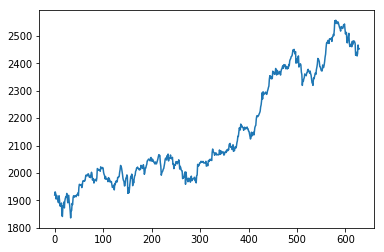

In [56]:
test_fill_in_missing_data(np.copy(kospi),3)

In [57]:
# fill in missing values
df['KOSPI'] = fill_in_missing_data(np.copy(kospi), 3)
df['KOSDAQ'] = fill_in_missing_data(np.copy(kosdaq), 3)

# LSTM

In [58]:
import tensorflow as tf

In [8]:
df.head()

,Date,KOSPI,KOSDAQ,Avgerage_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Avgerage_Wind_Speed,Average_Relative_humidity,Daylight_Hours,Cloud_Cover,Duration_of_Fog,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym
0,2016-01-04,1918.76,677.79,10.4,7.6,15.2,0.0,2.7,46.3,8.6,0.8,0.0,1200000,1.70885,0.66053,15.25185,69.49203,1.70459,74.50980,54.90196
1,2016-01-05,1930.53,684.07,5.3,3.2,8.1,0.2,3.1,40.9,0.0,7.0,0.0,900000,1.68328,0.54120,11.19918,58.96616,1.35089,20.91503,43.13725
2,2016-01-06,1925.43,687.27,4.8,1.8,9.9,0.0,2.9,34.5,7.7,5.6,0.0,950000,1.99437,0.45597,10.07841,62.38387,1.30827,25.49019,39.86928
3,2016-01-07,1904.33,679.66,3.9,1.1,8.5,0.0,2.7,47.3,8.6,0.9,0.0,880000,1.65771,0.47728,8.82553,63.78164,2.01142,22.87581,42.48366
4,2016-01-08,1917.62,682.56,2.5,-0.5,6.9,0.0,2.9,44.1,9.1,0.8,0.0,450000,1.35941,0.41336,7.26583,57.66641,1.44464,16.99346,24.83660


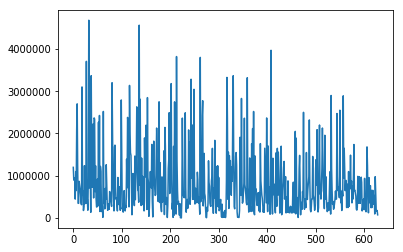

In [59]:
revenue = df['Revenue']
plt.plot(revenue)
plt.show()

In [10]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [60]:
seq_len = 5
data_dim = 1
output_dim = 1
hidden_dim = 10
iterations = 2000
scaled_revenue = np.reshape(MinMaxScaler(revenue), [-1,1])
print(scaled_revenue)

[[2.55833869e-01]
 [1.91607793e-01]
 [2.02312139e-01]
 [1.87326054e-01]
 [9.52686791e-02]
 [2.34425177e-01]
 [1.38086063e-01]
 [4.48512096e-01]
 [5.76964247e-01]
 [2.66538215e-01]
 [7.38599872e-02]
 [7.38599872e-02]
 [1.85185185e-01]
 [1.68486405e-01]
 [1.49004496e-01]
 [1.19246414e-01]
 [7.38599872e-02]
 [6.67951188e-02]
 [6.62599015e-01]
 [1.16677371e-01]
 [1.38086063e-01]
 [3.74652109e-02]
 [5.88739028e-02]
 [2.64397345e-01]
 [7.17191180e-02]
 [1.16677371e-01]
 [7.38599872e-02]
 [7.92121601e-01]
 [7.51445087e-02]
 [9.37700706e-02]
 [3.89638193e-02]
 [2.01669878e-01]
 [1.00000000e+00]
 [1.51359452e-01]
 [5.09098694e-01]
 [2.13016485e-01]
 [2.80453864e-02]
 [7.19546136e-01]
 [2.60415329e-01]
 [1.54784843e-01]
 [2.87304646e-01]
 [4.75487048e-01]
 [1.01049026e-01]
 [5.05887390e-01]
 [4.99892957e-01]
 [1.33311925e-01]
 [2.63755085e-01]
 [9.78377221e-02]
 [5.50203383e-02]
 [5.63048598e-02]
 [1.97388140e-01]
 [7.66431171e-02]
 [4.84050525e-01]
 [6.03725112e-02]
 [5.18304432e-01]
 [3.232712

In [49]:
dataX = []
dataY = []
for i in range(scaled_revenue.shape[0] - seq_len):
    _x = scaled_revenue[i:i+seq_len]
    _y = scaled_revenue[i+seq_len]
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

(array([[0.25583387],
       [0.19160779],
       [0.20231214],
       [0.18732605],
       [0.09526868]]), '->', array([0.23442518]))
(array([[0.19160779],
       [0.20231214],
       [0.18732605],
       [0.09526868],
       [0.23442518]]), '->', array([0.13808606]))
(array([[0.20231214],
       [0.18732605],
       [0.09526868],
       [0.23442518],
       [0.13808606]]), '->', array([0.4485121]))
(array([[0.18732605],
       [0.09526868],
       [0.23442518],
       [0.13808606],
       [0.4485121 ]]), '->', array([0.57696425]))
(array([[0.09526868],
       [0.23442518],
       [0.13808606],
       [0.4485121 ],
       [0.57696425]]), '->', array([0.26653821]))
(array([[0.23442518],
       [0.13808606],
       [0.4485121 ],
       [0.57696425],
       [0.26653821]]), '->', array([0.07385999]))
(array([[0.13808606],
       [0.4485121 ],
       [0.57696425],
       [0.26653821],
       [0.07385999]]), '->', array([0.07385999]))
(array([[0.4485121 ],
       [0.57696425],
       [0.266

(array([[0.12331407],
       [0.18454292],
       [0.20916292],
       [0.67951188],
       [0.19503318]]), '->', array([0.04388782]))
(array([[0.18454292],
       [0.20916292],
       [0.67951188],
       [0.19503318],
       [0.04388782]]), '->', array([0.0768572]))
(array([[0.20916292],
       [0.67951188],
       [0.19503318],
       [0.04388782],
       [0.0768572 ]]), '->', array([0.00256904]))
(array([[0.67951188],
       [0.19503318],
       [0.04388782],
       [0.0768572 ],
       [0.00256904]]), '->', array([0.36202098]))
(array([[0.19503318],
       [0.04388782],
       [0.0768572 ],
       [0.00256904],
       [0.36202098]]), '->', array([0.01370156]))
(array([[0.04388782],
       [0.0768572 ],
       [0.00256904],
       [0.36202098],
       [0.01370156]]), '->', array([0.58702633]))
(array([[0.0768572 ],
       [0.00256904],
       [0.36202098],
       [0.01370156],
       [0.58702633]]), '->', array([0.19460501]))
(array([[0.00256904],
       [0.36202098],
       [0.013

(array([[0.18090345],
       [0.09847998],
       [0.02569043],
       [0.18732605],
       [0.43780775]]), '->', array([0.02033826]))
(array([[0.09847998],
       [0.02569043],
       [0.18732605],
       [0.43780775],
       [0.02033826]]), '->', array([0.40355384]))
(array([[0.02569043],
       [0.18732605],
       [0.43780775],
       [0.02033826],
       [0.40355384]]), '->', array([0.06807964]))
(array([[0.18732605],
       [0.43780775],
       [0.02033826],
       [0.40355384],
       [0.06807964]]), '->', array([0.1031899]))
(array([[0.43780775],
       [0.02033826],
       [0.40355384],
       [0.06807964],
       [0.1031899 ]]), '->', array([0.08113894]))
(array([[0.02033826],
       [0.40355384],
       [0.06807964],
       [0.1031899 ],
       [0.08113894]]), '->', array([0.00214087]))
(array([[0.40355384],
       [0.06807964],
       [0.1031899 ],
       [0.08113894],
       [0.00214087]]), '->', array([0.06315564]))
(array([[0.06807964],
       [0.1031899 ],
       [0.081

(?, 10)
Step 0 - loss : 37.438873291
Step 1 - loss : 22.469581604
Step 2 - loss : 15.7709550858
Step 3 - loss : 14.4069957733
Step 4 - loss : 16.2264099121
Step 5 - loss : 17.6861362457
Step 6 - loss : 17.4138889313
Step 7 - loss : 16.2410507202
Step 8 - loss : 15.1163730621
Step 9 - loss : 14.4706249237
Step 10 - loss : 14.3256931305
Step 11 - loss : 14.5130624771
Step 12 - loss : 14.8198547363
Step 13 - loss : 15.071146965
Step 14 - loss : 15.1720161438
Step 15 - loss : 15.1105203629
Step 16 - loss : 14.9318294525
Step 17 - loss : 14.7048530579
Step 18 - loss : 14.4955816269
Step 19 - loss : 14.3509635925
Step 20 - loss : 14.2916717529
Step 21 - loss : 14.3116168976
Step 22 - loss : 14.3831882477
Step 23 - loss : 14.4676780701
Step 24 - loss : 14.5290222168
Step 25 - loss : 14.5458183289
Step 26 - loss : 14.516330719
Step 27 - loss : 14.4550123215
Step 28 - loss : 14.3838376999
Step 29 - loss : 14.3232564926
Step 30 - loss : 14.2861394882
Step 31 - loss : 14.2757749557
Step 32 - loss

Step 284 - loss : 14.1500530243
Step 285 - loss : 14.1474876404
Step 286 - loss : 14.1448316574
Step 287 - loss : 14.1420841217
Step 288 - loss : 14.1392421722
Step 289 - loss : 14.1363067627
Step 290 - loss : 14.1332740784
Step 291 - loss : 14.1301403046
Step 292 - loss : 14.1269054413
Step 293 - loss : 14.1235666275
Step 294 - loss : 14.1201248169
Step 295 - loss : 14.1165809631
Step 296 - loss : 14.1129302979
Step 297 - loss : 14.1091766357
Step 298 - loss : 14.1053161621
Step 299 - loss : 14.101354599
Step 300 - loss : 14.0972919464
Step 301 - loss : 14.0931301117
Step 302 - loss : 14.0888700485
Step 303 - loss : 14.0845184326
Step 304 - loss : 14.0800704956
Step 305 - loss : 14.0755414963
Step 306 - loss : 14.0709257126
Step 307 - loss : 14.066236496
Step 308 - loss : 14.0614776611
Step 309 - loss : 14.0566501617
Step 310 - loss : 14.0517644882
Step 311 - loss : 14.046831131
Step 312 - loss : 14.0418577194
Step 313 - loss : 14.0368432999
Step 314 - loss : 14.0318145752
Step 315 - 

Step 546 - loss : 13.6835851669
Step 547 - loss : 13.6719493866
Step 548 - loss : 13.6595878601
Step 549 - loss : 13.5760946274
Step 550 - loss : 13.6161575317
Step 551 - loss : 13.6578483582
Step 552 - loss : 13.6027469635
Step 553 - loss : 13.5788869858
Step 554 - loss : 13.5811843872
Step 555 - loss : 13.5212974548
Step 556 - loss : 13.4764184952
Step 557 - loss : 13.4990940094
Step 558 - loss : 13.4953155518
Step 559 - loss : 13.4749279022
Step 560 - loss : 13.4847297668
Step 561 - loss : 13.4668941498
Step 562 - loss : 13.4354772568
Step 563 - loss : 13.4294624329
Step 564 - loss : 13.4194250107
Step 565 - loss : 13.4050216675
Step 566 - loss : 13.4094772339
Step 567 - loss : 13.4142179489
Step 568 - loss : 13.3996601105
Step 569 - loss : 13.383523941
Step 570 - loss : 13.3780479431
Step 571 - loss : 13.3704576492
Step 572 - loss : 13.3606824875
Step 573 - loss : 13.3600978851
Step 574 - loss : 13.359621048
Step 575 - loss : 13.3507118225
Step 576 - loss : 13.3420591354
Step 577 -

Step 832 - loss : 10.3145980835
Step 833 - loss : 10.2982006073
Step 834 - loss : 10.2864904404
Step 835 - loss : 10.2702465057
Step 836 - loss : 10.2563323975
Step 837 - loss : 10.2406787872
Step 838 - loss : 10.2263851166
Step 839 - loss : 10.2105941772
Step 840 - loss : 10.1950063705
Step 841 - loss : 10.17918396
Step 842 - loss : 10.163775444
Step 843 - loss : 10.1476545334
Step 844 - loss : 10.1306972504
Step 845 - loss : 10.1148681641
Step 846 - loss : 10.0977287292
Step 847 - loss : 10.0817918777
Step 848 - loss : 10.0640716553
Step 849 - loss : 10.0471420288
Step 850 - loss : 10.0296211243
Step 851 - loss : 10.0123538971
Step 852 - loss : 9.99501514435
Step 853 - loss : 9.97727394104
Step 854 - loss : 9.9598236084
Step 855 - loss : 9.94182014465
Step 856 - loss : 9.92408752441
Step 857 - loss : 9.90633201599
Step 858 - loss : 9.88882255554
Step 859 - loss : 9.87247371674
Step 860 - loss : 9.85954189301
Step 861 - loss : 9.85370826721
Step 862 - loss : 9.87770366669
Step 863 - l

Step 1120 - loss : 5.79129695892
Step 1121 - loss : 6.04257249832
Step 1122 - loss : 5.86492538452
Step 1123 - loss : 5.81650352478
Step 1124 - loss : 5.96822452545
Step 1125 - loss : 5.7108836174
Step 1126 - loss : 5.80413198471
Step 1127 - loss : 5.87418079376
Step 1128 - loss : 5.6714887619
Step 1129 - loss : 5.78934574127
Step 1130 - loss : 5.71580505371
Step 1131 - loss : 5.70131969452
Step 1132 - loss : 5.7656750679
Step 1133 - loss : 5.61761760712
Step 1134 - loss : 5.62478733063
Step 1135 - loss : 5.66870689392
Step 1136 - loss : 5.60691976547
Step 1137 - loss : 5.64191484451
Step 1138 - loss : 5.59752893448
Step 1139 - loss : 5.52935504913
Step 1140 - loss : 5.55587387085
Step 1141 - loss : 5.54925966263
Step 1142 - loss : 5.55092668533
Step 1143 - loss : 5.54085445404
Step 1144 - loss : 5.51982784271
Step 1145 - loss : 5.47622919083
Step 1146 - loss : 5.46427106857
Step 1147 - loss : 5.4466342926
Step 1148 - loss : 5.45232200623
Step 1149 - loss : 5.44175863266
Step 1150 - lo

Step 1371 - loss : 3.59292387962
Step 1372 - loss : 3.62795305252
Step 1373 - loss : 3.67145109177
Step 1374 - loss : 3.64630484581
Step 1375 - loss : 3.64013981819
Step 1376 - loss : 3.57419395447
Step 1377 - loss : 3.52806615829
Step 1378 - loss : 3.48119401932
Step 1379 - loss : 3.45696353912
Step 1380 - loss : 3.45374631882
Step 1381 - loss : 3.4657998085
Step 1382 - loss : 3.4900302887
Step 1383 - loss : 3.50976848602
Step 1384 - loss : 3.54641199112
Step 1385 - loss : 3.55455493927
Step 1386 - loss : 3.59450912476
Step 1387 - loss : 3.58077979088
Step 1388 - loss : 3.60107898712
Step 1389 - loss : 3.55781435966
Step 1390 - loss : 3.53598117828
Step 1391 - loss : 3.47871255875
Step 1392 - loss : 3.43759346008
Step 1393 - loss : 3.3975148201
Step 1394 - loss : 3.37237119675
Step 1395 - loss : 3.35938358307
Step 1396 - loss : 3.35626673698
Step 1397 - loss : 3.36002969742
Step 1398 - loss : 3.36820173264
Step 1399 - loss : 3.3834104538
Step 1400 - loss : 3.40148639679
Step 1401 - lo

Step 1626 - loss : 2.46486711502
Step 1627 - loss : 2.52460074425
Step 1628 - loss : 2.58371591568
Step 1629 - loss : 2.60063028336
Step 1630 - loss : 2.62868309021
Step 1631 - loss : 2.55249452591
Step 1632 - loss : 2.49724006653
Step 1633 - loss : 2.42950296402
Step 1634 - loss : 2.39851379395
Step 1635 - loss : 2.39868545532
Step 1636 - loss : 2.4233250618
Step 1637 - loss : 2.45539712906
Step 1638 - loss : 2.47425365448
Step 1639 - loss : 2.50661611557
Step 1640 - loss : 2.50638246536
Step 1641 - loss : 2.52445268631
Step 1642 - loss : 2.51083898544
Step 1643 - loss : 2.51682949066
Step 1644 - loss : 2.50538849831
Step 1645 - loss : 2.50866794586
Step 1646 - loss : 2.50270223618
Step 1647 - loss : 2.50434207916
Step 1648 - loss : 2.49267888069
Step 1649 - loss : 2.4726934433
Step 1650 - loss : 2.43859267235
Step 1651 - loss : 2.40245389938
Step 1652 - loss : 2.3683655262
Step 1653 - loss : 2.34607505798
Step 1654 - loss : 2.33646631241
Step 1655 - loss : 2.33921480179
Step 1656 - l

Step 1878 - loss : 1.94060087204
Step 1879 - loss : 2.06186175346
Step 1880 - loss : 2.0835852623
Step 1881 - loss : 2.08891797066
Step 1882 - loss : 1.98691737652
Step 1883 - loss : 1.9295167923
Step 1884 - loss : 1.87404489517
Step 1885 - loss : 1.84997546673
Step 1886 - loss : 1.847448349
Step 1887 - loss : 1.8671913147
Step 1888 - loss : 1.9138314724
Step 1889 - loss : 1.95052480698
Step 1890 - loss : 2.00909376144
Step 1891 - loss : 2.00712013245
Step 1892 - loss : 2.02155995369
Step 1893 - loss : 1.97253084183
Step 1894 - loss : 1.94134700298
Step 1895 - loss : 1.89179706573
Step 1896 - loss : 1.86381959915
Step 1897 - loss : 1.83525419235
Step 1898 - loss : 1.81320977211
Step 1899 - loss : 1.79663085938
Step 1900 - loss : 1.78900408745
Step 1901 - loss : 1.79208374023
Step 1902 - loss : 1.80377757549
Step 1903 - loss : 1.82004308701
Step 1904 - loss : 1.83931088448
Step 1905 - loss : 1.87125360966
Step 1906 - loss : 1.90577745438
Step 1907 - loss : 1.9890857935
Step 1908 - loss 

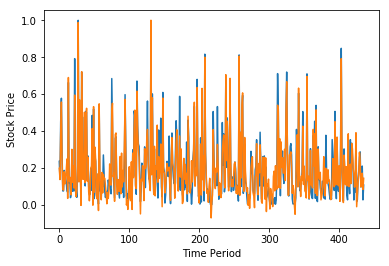

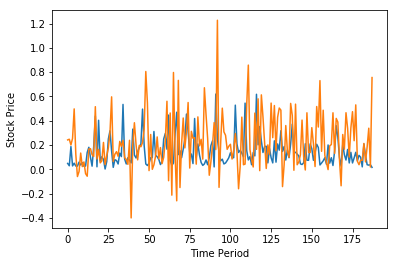

In [50]:
tf.reset_default_graph()

train_size = int(len(dataY)*0.7)
test_size = len(dataY) - train_size

trainX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:len(dataY)])

X = tf.placeholder(tf.float32, [None, seq_len, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)
print(outputs[:, -1].shape)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(0.02)
train = optimizer.minimize(loss)

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess :
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(iterations) :
        _, step_loss = sess.run([train, loss], feed_dict = {X:trainX,Y:trainY})
        print("Step {} - loss : {}".format(i, step_loss))
        
    train_predict = sess.run(Y_pred, feed_dict = {X:trainX})
    train_rmse_val = sess.run(rmse, feed_dict = {targets : trainY, predictions : train_predict})
    print("RMSE : {}".format(train_rmse_val))
    test_predict = sess.run(Y_pred, feed_dict = {X:testX})
    rmse_val = sess.run(rmse, feed_dict = {targets : testY, predictions:test_predict})
    print("RMSE : {}".format(rmse_val))
    
    plt.plot(trainY)
    plt.plot(train_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()